In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import gridspec as mpgs
import matplotlib as mpl
import numpy as np
import scipy as sp
from skimage import transform as skt
import os
import time
import multiprocessing as mp
import skimage.filters as skf
from scipy import ndimage as scnd
import hdf5storage as h5
from matplotlib_scalebar.scalebar import ScaleBar,SI_LENGTH_RECIPROCAL
import math
import numba
from skimage import restoration as skr
import sys
import pyfftw
import pymcr
%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams.update({'font.size': 25})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'figure.autolayout': True})

In [2]:
import sys
sys.path.append('/Users/7dm/stemtools')
import stemtools as st
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from matplotlib.colors import LinearSegmentedColormap as LSC
lin_burd = LSC.from_list('list', [(0, 35/255, 156/255), (0.95,0.95, 0.95),(249/255,56/255,34/255)], N=256)

In [5]:
st.tic()
datRhPt = h5.loadmat('RhPtThick.mat')
st.toc()

Elapsed time: 9.494926 seconds.



In [6]:
json1 = 'Particle1_ACSTEM_00.json'
json2 = 'Particle2_ACSTEM_00.json'
with open(json1) as json_1:
    info_1 = json.load(json_1)
with open(json2) as json_2:
    info_2 = json.load(json_2)

In [7]:
calib1 = info_1['spatial_calibrations'][0]['scale']
calib1_units = info_1['spatial_calibrations'][0]['units']

In [8]:
calib1

0.0078125

In [9]:
datRhPt.keys()

dict_keys(['particle1_00', 'particle1_90', 'particle1_SP', 'particle1_im', 'particle2_00', 'particle2_90', 'particle2_SP', 'particle2_im'])

In [10]:
image00 = datRhPt['particle1_00']
image90 = datRhPt['particle1_90']
imageDC = datRhPt['particle1_im']

In [11]:
calib1_units

'nm'

To ensure only the nanoparticle is picked, we will do a digital selected area electron diffraction - we will pick two diffraction spots and then mask the image so that we will analyze only the image where the diffraction spots came from.

In [12]:
imageDC = np.rot90(imageDC)
imageDC.shape

(1970, 1970)

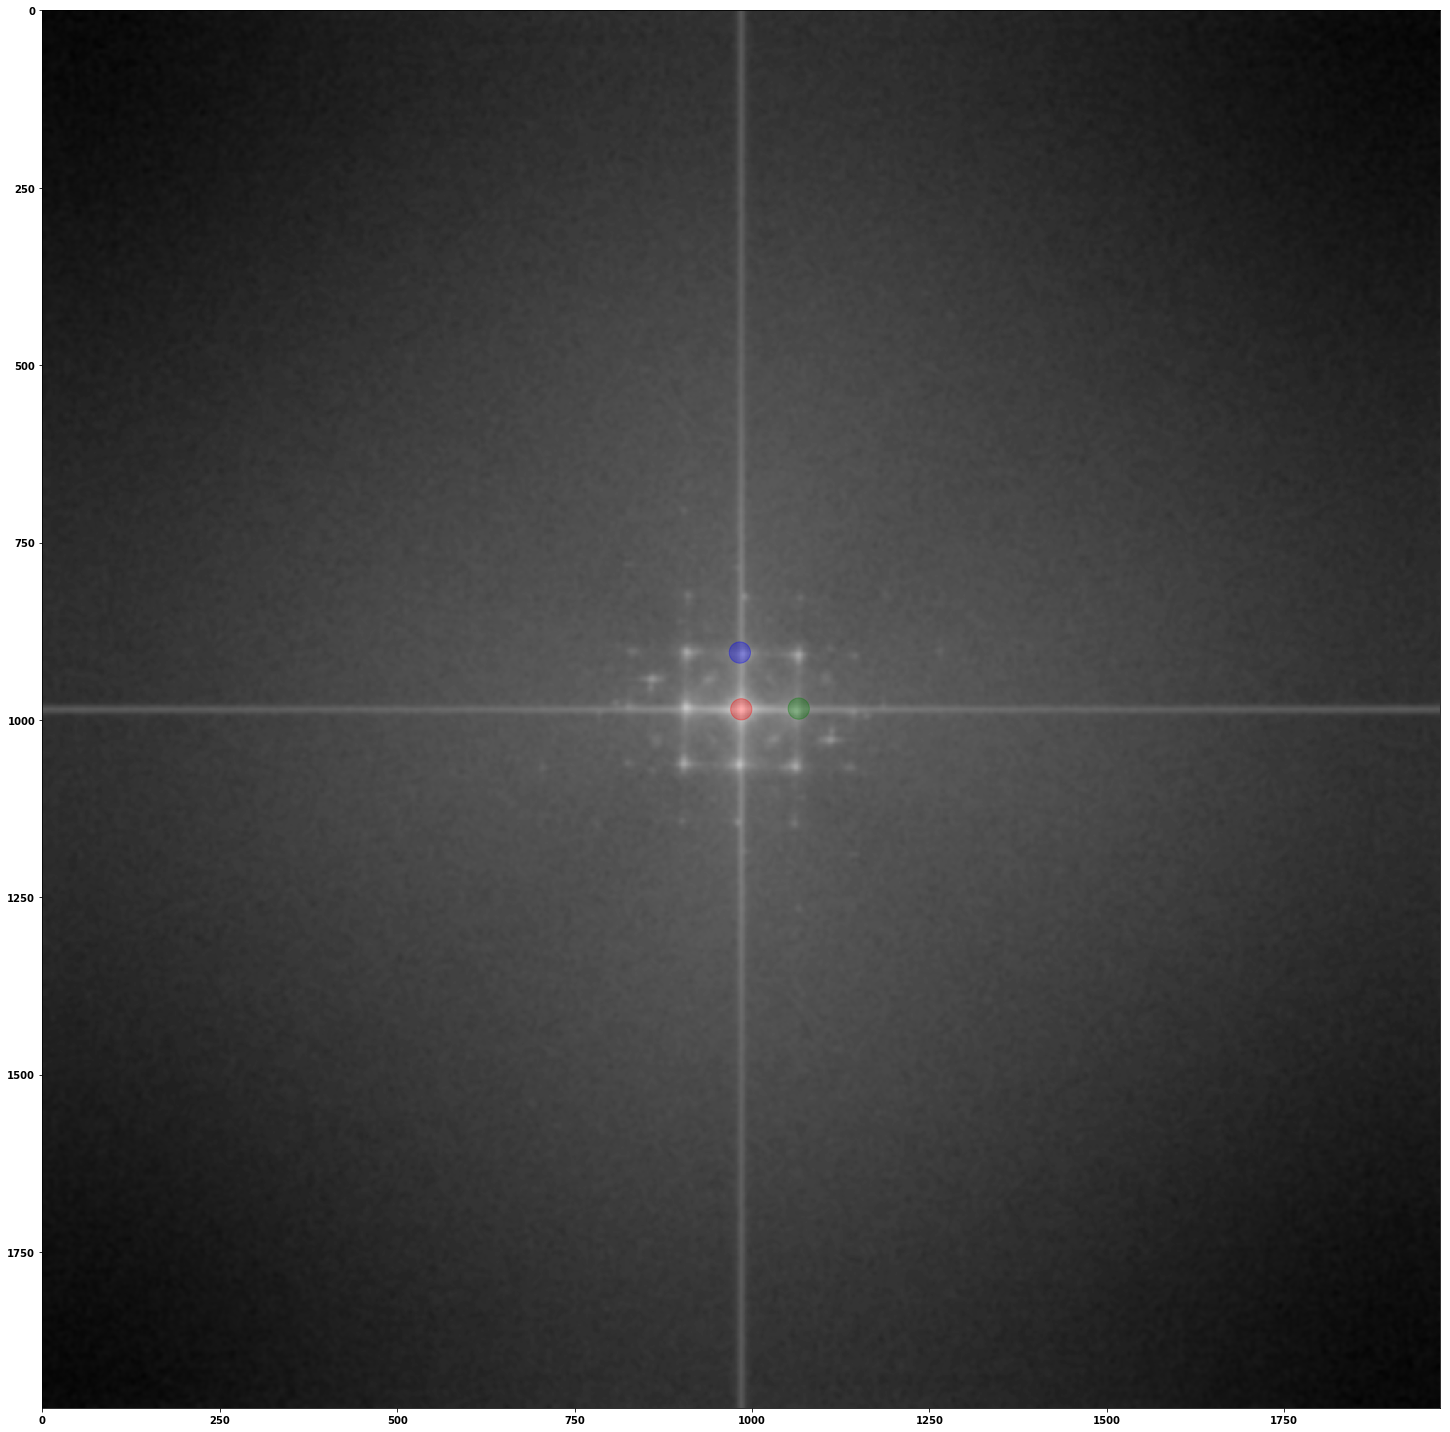

In [13]:
circ_c, circ_a, circ_b = st.gpa.find_diffraction_spots(image=imageDC,
                                                       circ_0=(985,985),
                                                       circ_1=(983,905),
                                                       circ_2=(1066,984))

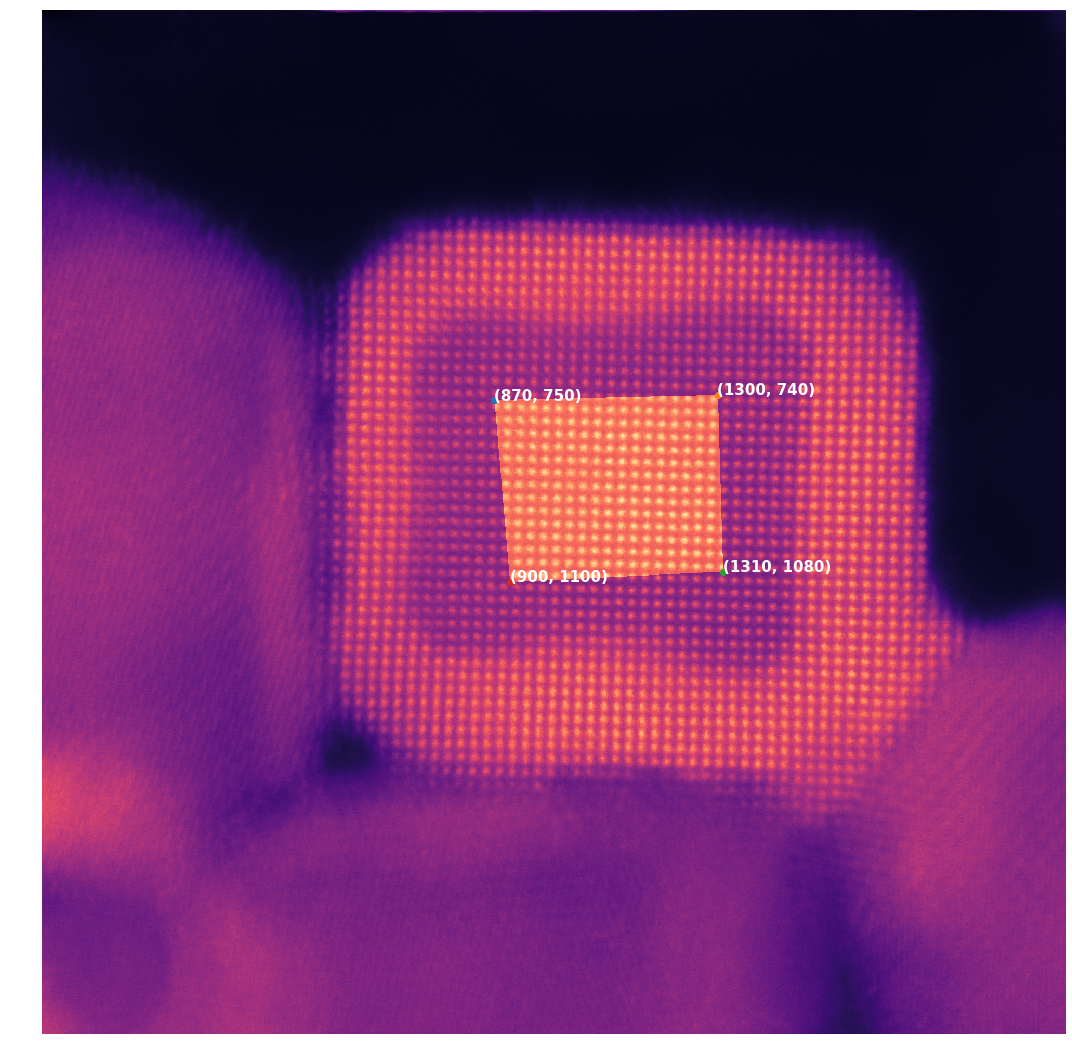

In [14]:
A = (870,750)
B = (1300,740)
C = (1310,1080)
D = (900,1100)
ref_matrix = st.gpa.define_reference(imageDC,A,B,C,D)

In [37]:
st.tic()
gvec_a = st.gpa.circ_to_G(circ_a,imageDC)
gvec_b = st.gpa.circ_to_G(circ_b,imageDC)
P1_a = st.gpa.p_matrix(gvec_a,imageDC)
P1_b = st.gpa.p_matrix(gvec_b,imageDC)
gvec_a2, P2_a = st.gpa.refined_P(P1_a,gvec_a,ref_matrix,imageDC,0.01)
gvec_b2, P2_b = st.gpa.refined_P(P1_b,gvec_b,ref_matrix,imageDC,0.01)
a_matrix = st.gpa.get_a_matrix(gvec_a2,gvec_b2)
U_x, U_y = st.gpa.get_u_matrices(P2_a,P2_b,a_matrix)
e_xx,e_yy,e_theta,e_diag = st.gpa.get_strain(U_x,U_y)
st.toc()

Elapsed time: 5.337629 seconds.



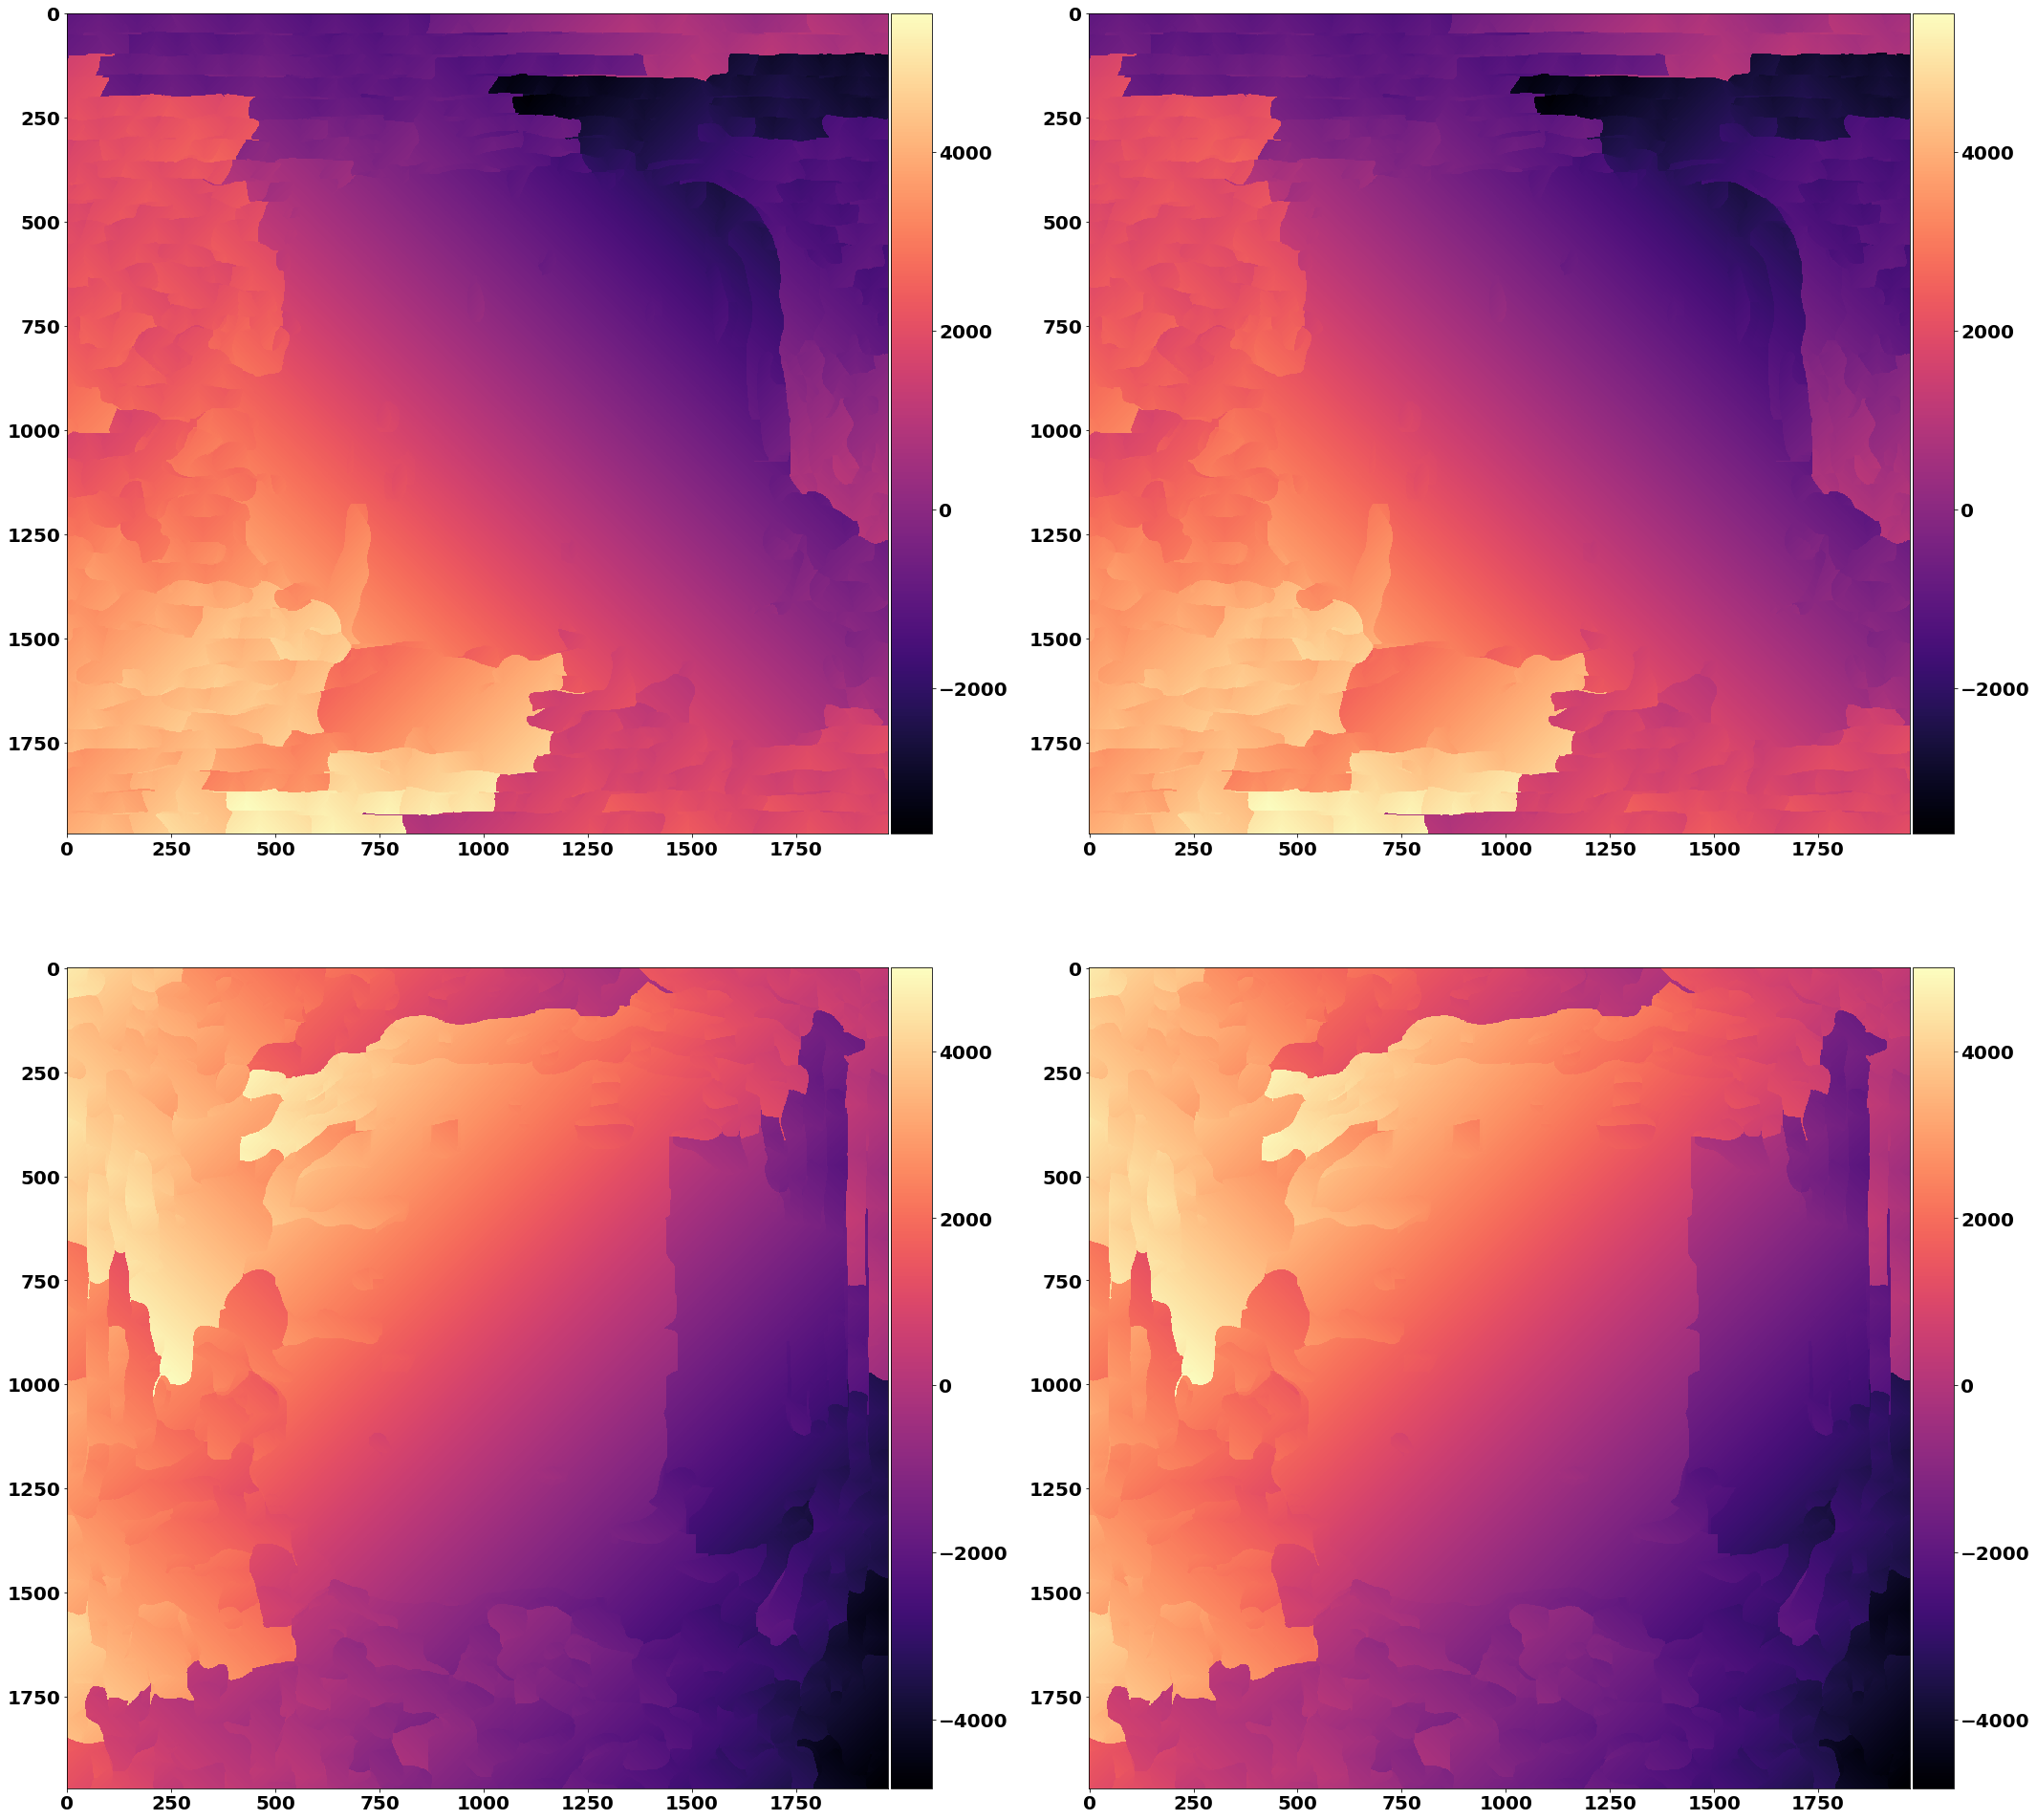

In [38]:
plt.figure(figsize=(30,30))
plt.subplot(2,2,1)
im = plt.imshow(P1_a)
st.util.sane_colorbar(im)
plt.subplot(2,2,2)
im = plt.imshow(P2_a)
st.util.sane_colorbar(im)
plt.subplot(2,2,3)
im = plt.imshow(P1_b)
st.util.sane_colorbar(im)
plt.subplot(2,2,4)
im = plt.imshow(P2_b)
st.util.sane_colorbar(im)

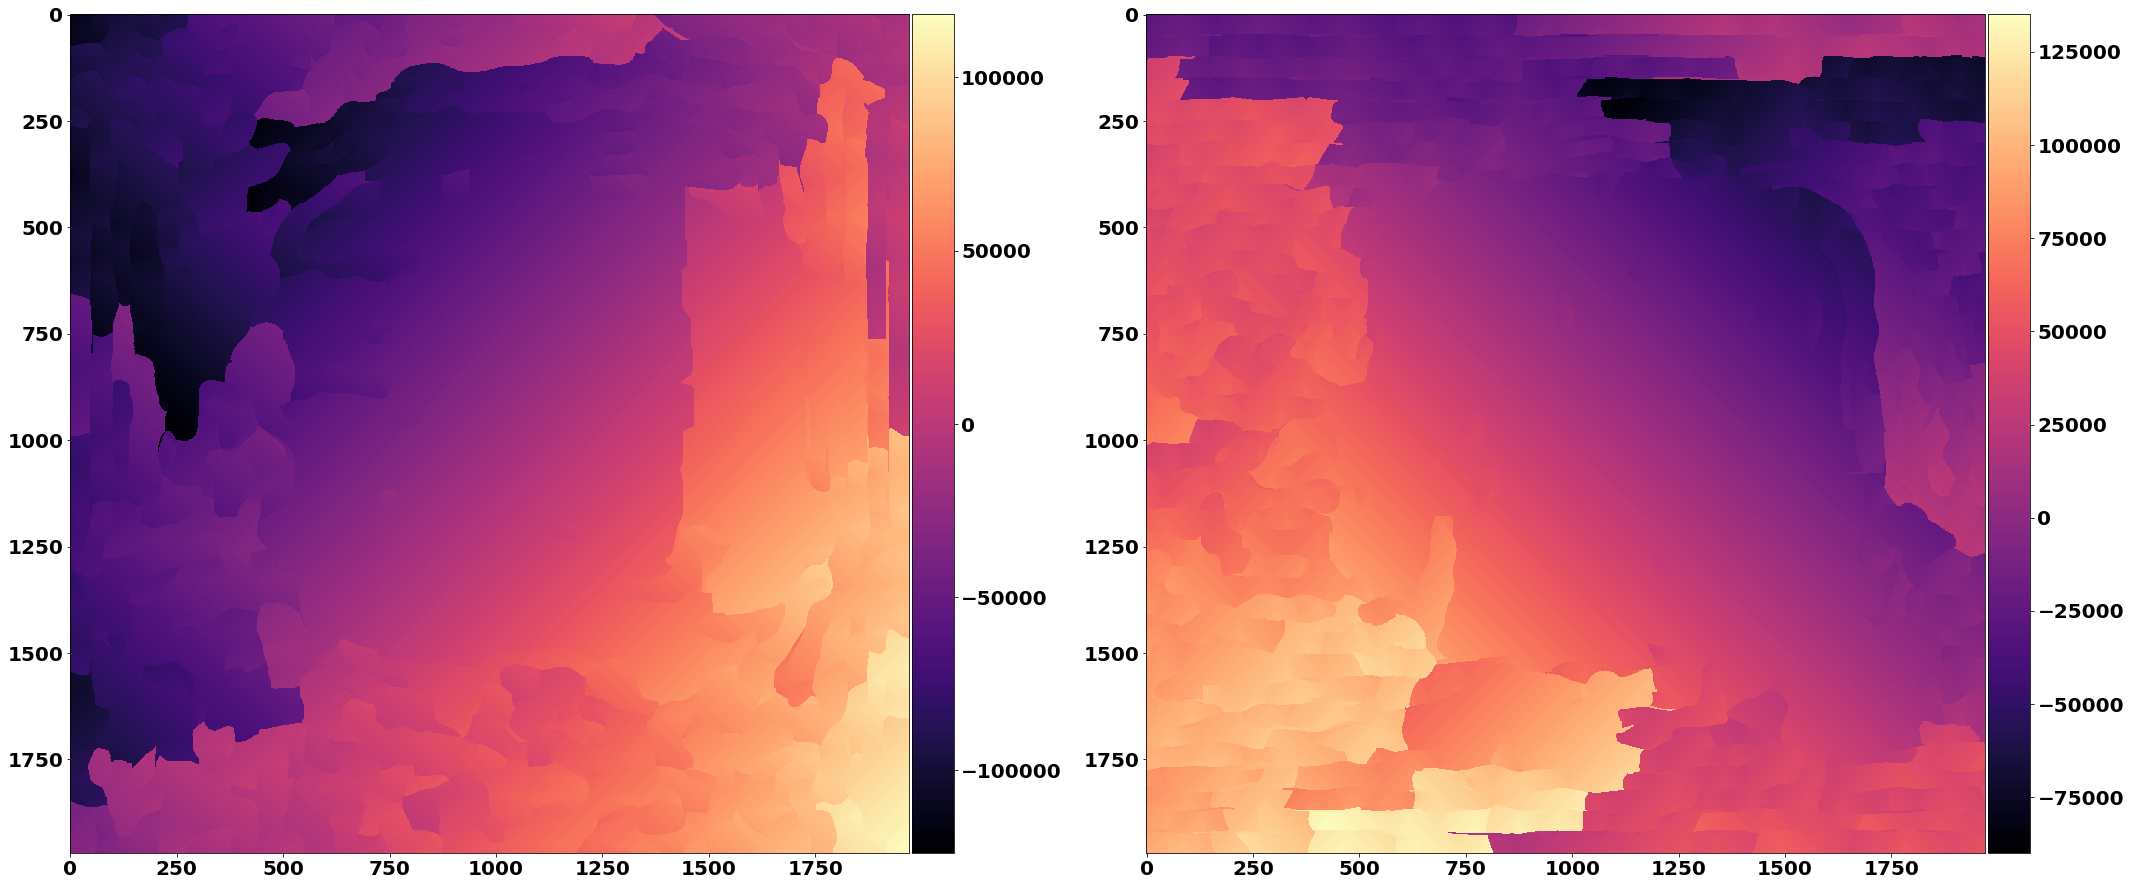

In [39]:
plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
im = plt.imshow(U_x)
st.util.sane_colorbar(im)
plt.subplot(1,2,2)
im = plt.imshow(U_y)
st.util.sane_colorbar(im)

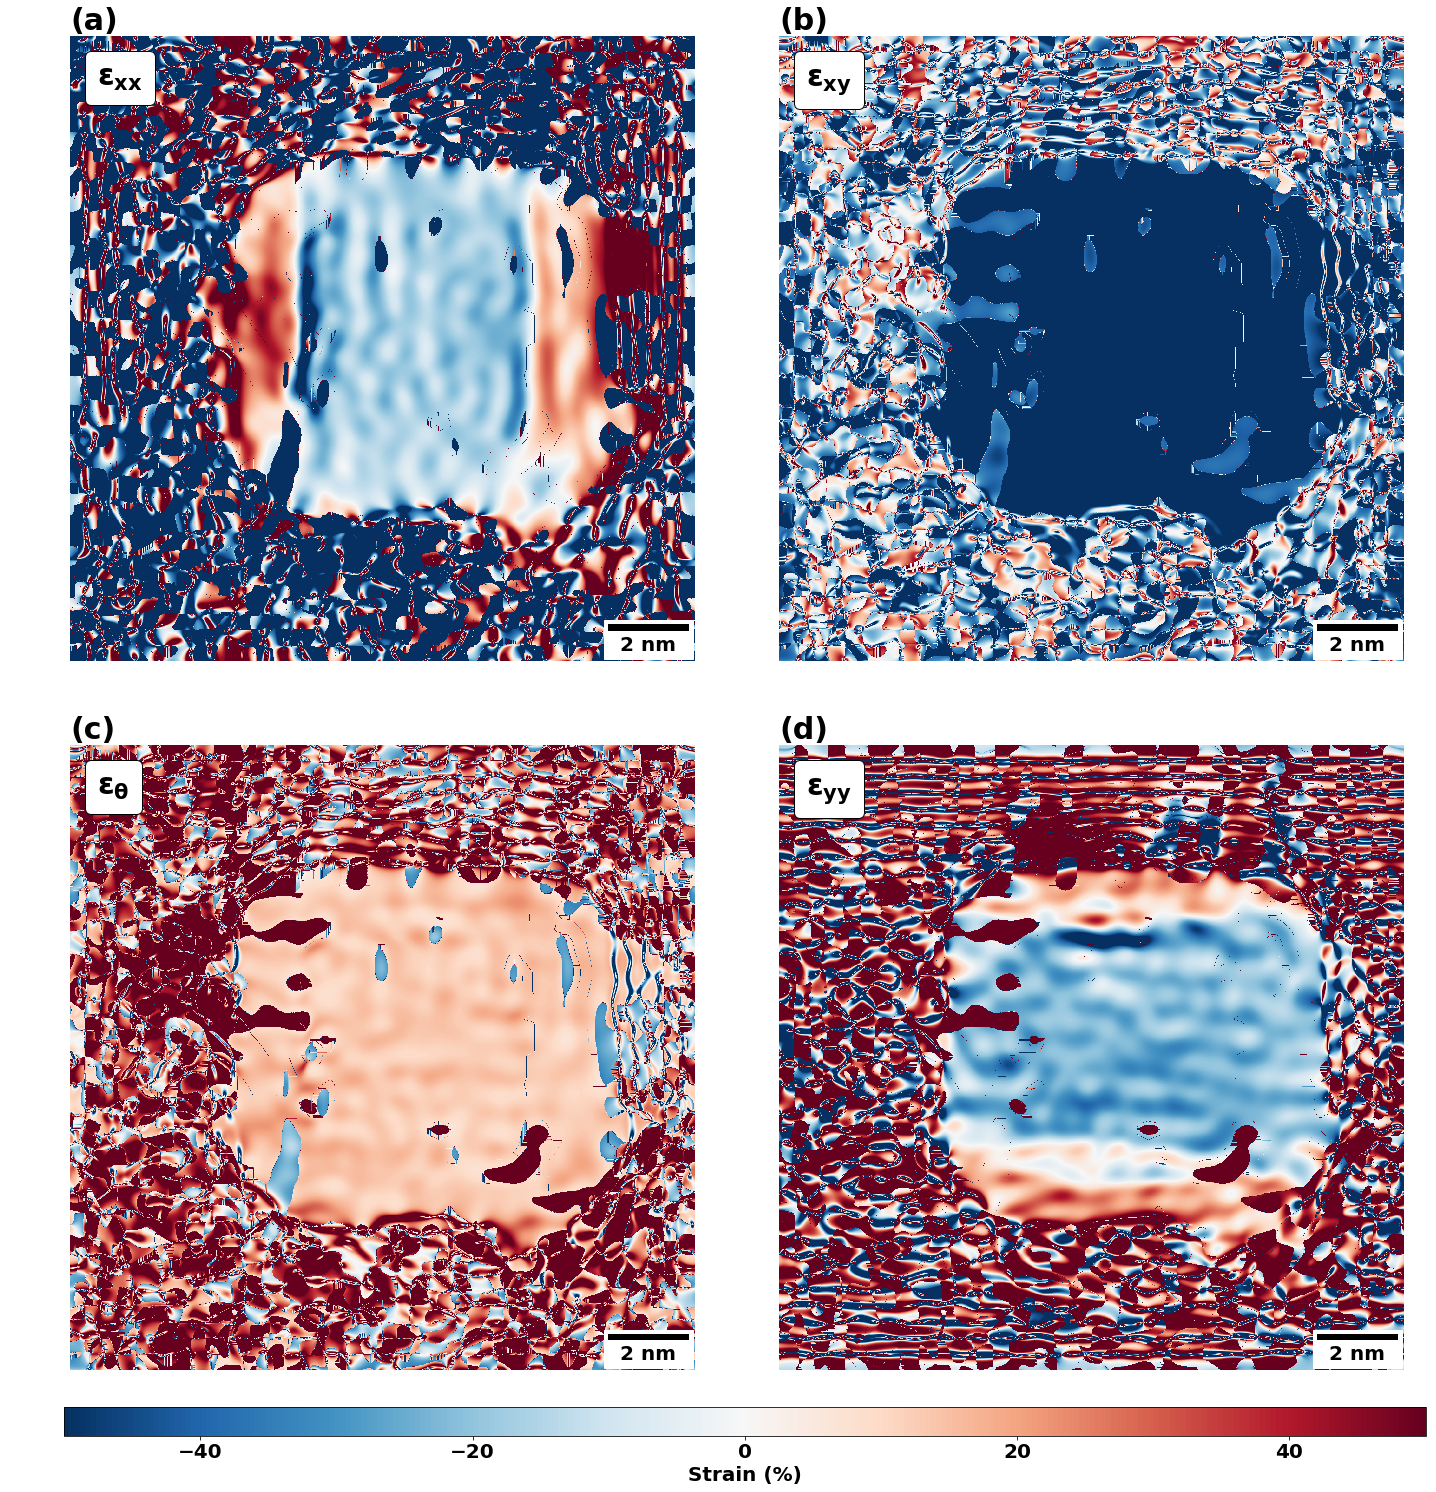

In [40]:
from matplotlib.offsetbox import AnchoredText

vm = 50
#vm = 100*np.amax(np.abs(np.concatenate((strainDC_yy,strainDC_xx,strainDC_xy,strainDC_th),axis=1)))
sc_font={'weight' : 'bold',
         'size'   : 20}
mpl.rc('font', **sc_font)
title_font = {'weight': 'bold',
              'size': 30,
             }

fig =plt.figure(figsize=(20,20))

gs = mpgs.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])

im = ax1.imshow(-100*e_xx,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
ax1.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{xx}}$',
                  prop=dict(size=30), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
ax1.set_title(label='(a)',loc='left',fontdict=title_font)
ax1.axis('off')


im = ax2.imshow(-100*e_diag,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
ax2.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{xy}}$',
                  prop=dict(size=30), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at)
ax2.set_title(label='(b)',loc='left',fontdict=title_font)
ax2.axis('off')


im = ax3.imshow(-100*e_theta,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
ax3.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{\theta}}$',
                  prop=dict(size=30), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at)
ax3.set_title(label='(c)',loc='left',fontdict=title_font)
ax3.axis('off')


im = ax4.imshow(-100*e_yy,vmin=-vm, vmax=vm,cmap='RdBu_r')
scalebar = ScaleBar(calib1,calib1_units)
scalebar.location = 'lower right'
scalebar.box_alpha = 1
scalebar.color = 'k'
ax4.add_artist(scalebar)
at = AnchoredText(r'$\mathrm{\epsilon_{yy}}$',
                  prop=dict(size=30), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax4.add_artist(at)
ax4.set_title(label='(d)',loc='left',fontdict=title_font)
ax4.axis('off')

p1 = ax1.get_position().get_points().flatten()
p4 = ax4.get_position().get_points().flatten()

ax_cbar = fig.add_axes([p1[0] - 0.075, -0.01, p4[2] + 0.05, 0.02])
cbar = plt.colorbar(im, cax=ax_cbar, orientation='horizontal')
cbar.set_label('Strain (%)',**sc_font)

plt.autoscale()
plt.savefig('Particle1_DC_GPA_ACSTEM.pdf',bbox_inches = 'tight')